
# ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [1]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
EPOCHS = 30 
BATCH_SIZE = 32

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K_hat = 8                  # number of VMD modes (tuneable)
alpha_hat = 1705             # VMD alpha (tuneable)
tau_hat = 0.05805898025979961                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector

2025-11-22 21:09:06.615872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-22 21:09:06.754718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763833146.814003    3606 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763833146.828404    3606 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-22 21:09:06.998334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
save_dir = os.path.expanduser("~/Project/AttnLstm/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


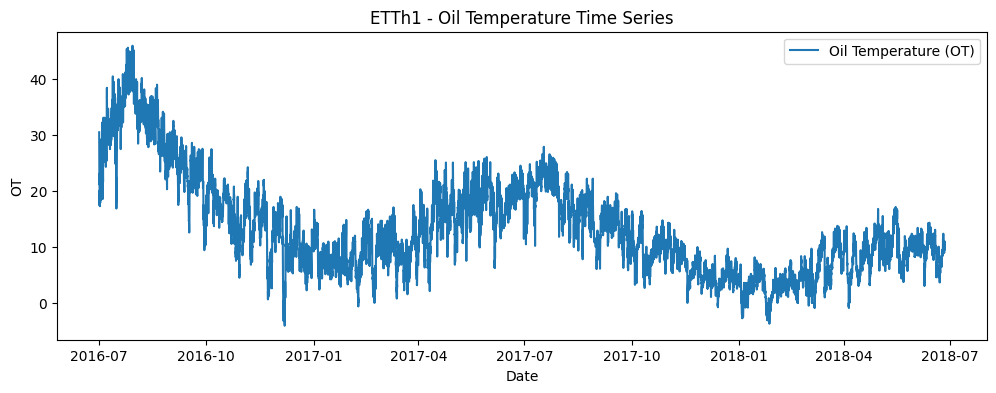

In [4]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [5]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

    
def train_test(alpha=1, tau=1, K=1):
    # --- VMD on train and test ---
    u_train, _, _ = VMD(train_data[TARGET_COL].values, alpha, tau, K, DC=0, init=1, tol=1e-7)
    u_test,  _, _ = VMD(test_data[TARGET_COL].values,  alpha, tau, K, DC=0, init=1, tol=1e-7)

    vmd_train = np.stack(u_train, axis=1)
    vmd_test  = np.stack(u_test,  axis=1)

    # --- Scale features & target ---
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    train_scaled_vmd = scaler_x.fit_transform(vmd_train)
    train_scaled_target = scaler_y.fit_transform(train_data[[TARGET_COL]])
    test_scaled_vmd  = scaler_x.transform(vmd_test)
    test_scaled_target  = scaler_y.transform(test_data[[TARGET_COL]])

    # --- Sequence generation (aligned) ---
    X_train_vmd, y_train_vmd = create_sequences(train_scaled_vmd, train_scaled_target, SEQ_LEN)
    X_test_vmd,  y_test_vmd  = create_sequences(test_scaled_vmd,  test_scaled_target,  SEQ_LEN)
    X_train_simple, y_train_simple = create_sequences(train_scaled_target,train_scaled_target,SEQ_LEN)
    X_test_simple, y_test_simple = create_sequences(test_scaled_target,test_scaled_target,SEQ_LEN)
    y_test_simple_true = scaler_y.inverse_transform(y_test_simple.reshape(-1, 1)).flatten()
    y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)

    return y_test_vmd_true,y_test_simple_true,scaler_y,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,X_train_simple,y_train_simple,X_test_simple,y_test_simple


# AttnLSTM+VMD+GA
    - VMD parameters (like alpha, K, tau, etc.)

    - Model parameters (like number of LSTM units, learning rate, dropout, etc.)

We’ll use a Genetic Algorithm (GA) for joint optimization of both sets.

Why this architecture?

- The **stacked LSTM layers** capture hierarchical temporal‑dependencies within the input sequence.  
- The **Attention() layer** allows the model to dynamically focus on different time‑steps of the sequence (via self‑attention over the LSTM outputs).  
- By extracting both the **last output** and the **mean of the attention context**, the model combines both “summary” information and distributed attention information.  
- This **hybrid structure (LSTM + Attention)** is especially useful in non‑stationary, complex time series where long‑range dependencies and varying importance of past steps matter.

Relevant Papers on Attention-LSTM (AttLSTM) based on my Architecture Implementation

Here are some peer-reviewed, indexed papers that implement LSTM with attention (Attention-LSTM / AttLSTM):

1. **Attention‑based LSTM network‑assisted time series forecasting models for petroleum production**  
   - *Kumar et al., 2023, Engineering Applications of Artificial Intelligence, Vol 123, Article 106440*  
   - Applies LSTM with attention for time-series forecasting in petroleum production.  
   - [Link to article](https://dl.acm.org/doi/abs/10.1016/j.engappai.2023.106440?utm_source=chatgpt.com)  
   - **JCR-indexed**.

2. **Time series prediction model based on LSTM-attention-LSTM model**  
   - *Wen & Li, 2023, IEEE Access*  
   - Proposes an encoder-decoder LSTM with attention mechanism in between.  
   - [Link to article](https://doaj.org/article/a0f2861a315340bcbb4f985c015da50e?utm_source=chatgpt.com)  
   - Fully peer-reviewed and indexed.

3. **Multivariate Time Series Data Prediction Based on ATT-LSTM Model**  
   - *Ju et al., 2021, Applied Sciences (MDPI), Vol 11, 20, 9373*  
   - Implements ATT-LSTM for multivariate time series prediction.  
   - [Link to article](https://www.mdpi.com/2076-3417/11/20/9373?utm_source=chatgpt.com)  
   - Peer-reviewed, open-access journal.

> **Note:** These papers validate the use of Attention-LSTM models in forecasting tasks. Variations may exist in attention mechanisms (temporal, variable) and encoder-decoder designs.


Relevant Papers on VMD + GA Hybrid Methods

Here are some peer-reviewed / indexed papers that implement VMD (Variational Mode Decomposition) combined with GA (Genetic Algorithm) for forecasting or signal decomposition:

1. **A genetic algorithm optimized hybrid model for agricultural price forecasting based on VMD and LSTM network**  
   - Applies GA-optimised VMD to decompose agricultural commodity price series, then uses LSTM for prediction.  
   - GA is used to optimise VMD parameter selection.  
   - Application domain: agricultural commodity prices (maize, palm oil, soybean oil).  
   - [PubMed link](https://pubmed.ncbi.nlm.nih.gov/40121306/?utm_source=chatgpt.com)  

2. **Variational Mode Decomposition based Machine Learning Models Optimized with Genetic Algorithm for Price Forecasting**  
   - Authors: Pankaj Das, Achal Lama, Girish Kumar Jha  
   - Published in: *Journal of the Indian Society of Agricultural Statistics*, 76(3), 2022, pp141–150  
   - Uses VMD + GA hybrid ML models (SVR + RF) for price forecasting.  
   - [Link to PDF](https://krishi.icar.gov.in/jspui/bitstream/123456789/76648/1/VMD-GA%20based%20ML%20models.pdf?utm_source=chatgpt.com)  

3. **Short-term power grid load forecasting based on optimized VMD and GA-BP**  
   - Published in: *International Journal of Low-Carbon Technologies*  
   - Application: short-term load forecasting in regional power grids using VMD and GA-optimized backpropagation (BP) network.  
   - [Oxford Academic link](https://academic.oup.com/ijlct/article/doi/10.1093/ijlct/ctae039/7644400?utm_source=chatgpt.com)  

4. **Wind power forecasting based on improved variational mode decomposition and permutation entropy**  
   - Refers to GA-VMD stacking in wind power forecasting models.  
   - Published in: *Clean Energy*  
   - Application: wind power prediction.  
   - [Link](https://academic.oup.com/ce/article/7/5/1032/7279331?utm_source=chatgpt.com)  

5. **A hybrid forecasting method for quantitative investments based on GA-VMD and SSA-DELM optimization**  
   - Authors: Ruitian Zhang, Zebang Deng, Yicheng Shen  
   - Published in: *Business & Management*, Vol 33  
   - Application: quantitative investment modelling using GA-optimized VMD.  
   - [Link](https://bcpublication.org/index.php/BM/article/view/2730?utm_source=chatgpt.com)  

> **Note:** These papers demonstrate the use of GA to optimize VMD parameters before applying ML models (LSTM, BP, SVR, etc.) for forecasting or signal decomposition.



🧬 Generation 1/3
  Candidate 1: MSE = 0.0001, params = {'alpha': 2401.745873509103, 'tau': 0.46459067420583405, 'K': 7, 'lstm1_units': 96, 'lstm2_units': 96, 'dense_units': 64}
  Candidate 2: MSE = 0.0001, params = {'alpha': 2424.6562388711304, 'tau': 0.08653112544274288, 'K': 6, 'lstm1_units': 128, 'lstm2_units': 48, 'dense_units': 16}
  Candidate 3: MSE = 0.0002, params = {'alpha': 1685.5860583492072, 'tau': 0.35724521770706813, 'K': 3, 'lstm1_units': 64, 'lstm2_units': 96, 'dense_units': 48}
  Candidate 4: MSE = 0.0001, params = {'alpha': 1853.093304802348, 'tau': 0.06125222868198199, 'K': 8, 'lstm1_units': 160, 'lstm2_units': 64, 'dense_units': 32}
  ✅ Best so far: {'alpha': 1853.093304802348, 'tau': 0.06125222868198199, 'K': 8, 'lstm1_units': 160, 'lstm2_units': 64, 'dense_units': 32}

🧬 Generation 2/3
  Candidate 1: MSE = 0.0001, params = {'alpha': 1853.093304802348, 'tau': 0.06125222868198199, 'K': 8, 'lstm1_units': 160, 'lstm2_units': 64, 'dense_units': 32}
  Candidate 2: MSE 

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 24, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 24, 96)         │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 24, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_26              │ (None, 96)             │         9,408 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_25 (Reshape)            │ (None, 1, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,729 (506.75 KB)

 Trainable params: 129,729 (506.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0150 - mae: 0.0758 - val_loss: 6.7113e-04 - val_mae: 0.0199
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 2.3063e-04 - val_mae: 0.0117
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.4809e-04 - mae: 0.0193 - val_loss: 1.1694e-04 - val_mae: 0.0082
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.4941e-04 - mae: 0.0161 - val_loss: 8.4427e-05 - val_mae: 0.0070
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.6753e-04 - mae: 0.0144 - val_loss: 9.0162e-05 - val_mae: 0.0072
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.3557e-04 - mae: 0.0137 - val_loss: 8.7583e-05 - val_mae: 0.0072
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.0103e-04 - mae: 0.0131 - val_loss: 8.0686e-05 - val_mae: 0.0068
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.8580e-04 - mae: 0.0126 - val_loss: 1.0275e-04 - val_mae:

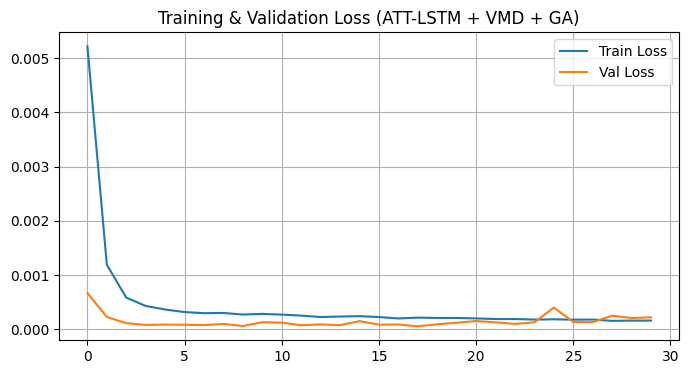

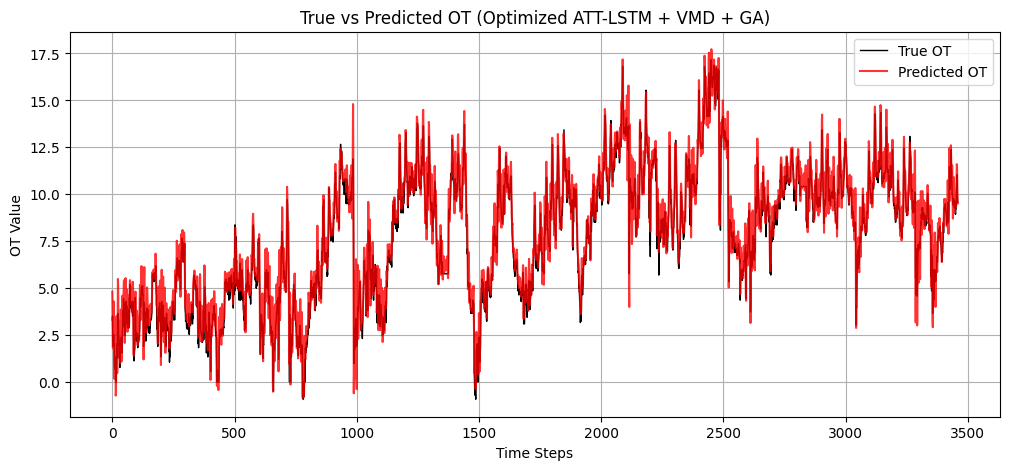

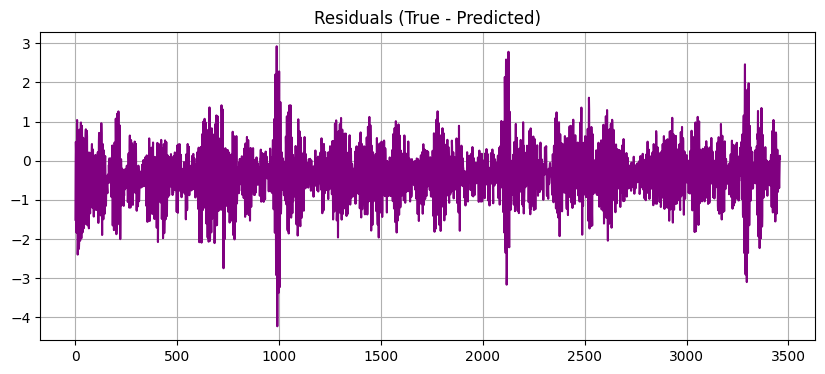

In [8]:
# =====================================================
# Complete ATT-LSTM + VMD + GA Setup (Corrected)
# =====================================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import random
import matplotlib.pyplot as plt
from vmdpy import VMD
from tensorflow.keras.layers import Reshape

# =====================================================
# 1️⃣ Global Config
# =====================================================
SEQ_LEN = SEQ_LEN
EPOCHS_OPT = 6        # GA fitness epochs
EPOCHS_FINAL = EPOCHS     # final retraining
BATCH_SIZE = BATCH_SIZE

# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])

# =====================================================
# 3️⃣ ATT-LSTM Model Builder
# =====================================================

def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model
# =====================================================
# 4️⃣ Fitness Function for GA
# =====================================================
def fitness(params, data):
    alpha, tau, K = params['alpha'], params['tau'], params['K']
    lstm1_units, lstm2_units, dense_units = (
        params['lstm1_units'], params['lstm2_units'], params['dense_units']
    )
    
    # Generate train/test data (train_test function should return proper arrays)
    y_test_vmd_true, _, scaler_y, X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd, *_ = train_test(alpha, tau, K)
    
    model = build_attlstm_model(
        input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
        lstm1_units=lstm1_units,
        lstm2_units=lstm2_units,
        dense_units=dense_units
    )
    
    history = model.fit(
        X_train_vmd, y_train_vmd,
        validation_data=(X_test_vmd, y_test_vmd),
        epochs=EPOCHS_OPT,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    
    return min(history.history['val_loss'])

# =====================================================
# 5️⃣ GA Helper Functions
# =====================================================
def random_params():
    return {
        'alpha': random.uniform(500, 3000),
        'tau': random.uniform(0.0, 0.5),
        'K': random.randint(3, 8),
        'lstm1_units': random.choice([64, 96, 128, 160]),
        'lstm2_units': random.choice([32, 48, 64, 96]),
        'dense_units': random.choice([16, 32, 48, 64])
    }

def mutate(params):
    new_params = params.copy()
    if random.random() < 0.4:
        new_params['alpha'] *= random.uniform(0.8, 1.2)
    if random.random() < 0.4:
        new_params['tau'] += random.uniform(-0.05, 0.05)
    if random.random() < 0.3:
        new_params['K'] = max(2, min(10, new_params['K'] + random.choice([-1, 1])))
    if random.random() < 0.4:
        new_params['lstm1_units'] = random.choice([64, 96, 128, 160])
    if random.random() < 0.4:
        new_params['lstm2_units'] = random.choice([32, 48, 64, 96])
    if random.random() < 0.4:
        new_params['dense_units'] = random.choice([16, 32, 48, 64])
    return new_params

def evolve_population(data, pop_size=4, generations=3):
    population = [random_params() for _ in range(pop_size)]
    for g in range(generations):
        print(f"\n🧬 Generation {g+1}/{generations}")
        scores = []
        for i, params in enumerate(population):
            mse = fitness(params, data)
            scores.append((mse, params))
            print(f"  Candidate {i+1}: MSE = {mse:.4f}, params = {params}")
        scores.sort(key=lambda x: x[0])
        best_params = scores[0][1]
        print(f"  ✅ Best so far: {best_params}")
        # Evolve next generation
        new_pop = [scores[0][1], scores[1][1]]
        while len(new_pop) < pop_size:
            parent = random.choice(new_pop)
            new_pop.append(mutate(parent))
        population = new_pop
    return best_params

# =====================================================
# 6️⃣ Run GA Optimization
# =====================================================
best_params = evolve_population(df, pop_size=4, generations=3)
print("\n🏁 Best parameters found:", best_params)

# =====================================================
# 7️⃣ Retrain with Best Params (No Leakage)
# =====================================================
alpha, tau, K = best_params['alpha'], best_params['tau'], best_params['K']
lstm1_units, lstm2_units, dense_units = (
    best_params['lstm1_units'], best_params['lstm2_units'], best_params['dense_units']
)

y_test_vmd_true, _, scaler_y, X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd, *_ = train_test(alpha, tau, K)

model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=lstm1_units,
    lstm2_units=lstm2_units,
    dense_units=dense_units
)
model.summary()

history_attlstm_vmd_ga = model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_vmd_ga_scaled = model.predict(X_test_vmd)
y_pred_attlstm_vmd_ga_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd_ga.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd_ga.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD + GA)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_ga_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD + GA)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_attlstm_vmd_ga_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


# AttnLSTM+VMD+Bayesian

[I 2025-11-22 22:02:59,513] A new study created in memory with name: no-name-e5316259-fde2-4509-966e-155f6d02317a
[I 2025-11-22 22:03:17,755] Trial 0 finished with value: 0.00026061898097395897 and parameters: {'alpha': 2222.951901232697, 'tau': 0.13069133500869456, 'K': 4, 'lstm1_units': 96, 'lstm2_units': 32, 'dense_units': 64}. Best is trial 0 with value: 0.00026061898097395897.
[I 2025-11-22 22:03:36,547] Trial 1 finished with value: 0.00016831998073030263 and parameters: {'alpha': 2941.452509762153, 'tau': 0.10772456993982743, 'K': 6, 'lstm1_units': 160, 'lstm2_units': 32, 'dense_units': 48}. Best is trial 1 with value: 0.00016831998073030263.
[I 2025-11-22 22:03:55,296] Trial 2 finished with value: 0.00023570451594423503 and parameters: {'alpha': 2940.640736482482, 'tau': 0.43678809401834257, 'K': 6, 'lstm1_units': 128, 'lstm2_units': 48, 'dense_units': 16}. Best is trial 1 with value: 0.00016831998073030263.
[I 2025-11-22 22:04:13,274] Trial 3 finished with value: 0.000225627212


🏁 Best parameters found:
{'alpha': 2941.452509762153, 'tau': 0.10772456993982743, 'K': 6, 'lstm1_units': 160, 'lstm2_units': 32, 'dense_units': 48}


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 24, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_111 (LSTM)                 │ (None, 24, 160)        │       106,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 24, 160)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_32              │ (None, 160)            │        25,920 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_31 (Reshape)            │ (None, 1, 160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_112 (LSTM)                 │ (None, 32)             │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,137 (621.63 KB)

 Trainable params: 159,137 (621.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0194 - mae: 0.0863 - val_loss: 6.5698e-04 - val_mae: 0.0215
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 2.9716e-04 - val_mae: 0.0131
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.0629e-04 - mae: 0.0214 - val_loss: 2.3383e-04 - val_mae: 0.0119
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 5.7266e-04 - mae: 0.0180 - val_loss: 1.4676e-04 - val_mae: 0.0092
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 5.6673e-04 - mae: 0.0177 - val_loss: 1.6755e-04 - val_mae: 0.0102
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 5.1885e-04 - mae: 0.0171 - val_loss: 1.2342e-04 - val_mae: 0.0084
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.8151e-04 - mae: 0.0164 - val_loss: 1.1455e-04 - val_mae: 0.0080
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.2886e-04 - mae: 0.0155 - val_loss: 1.2996e-04 - val_mae:

NameError: name 'y_pred_true' is not defined

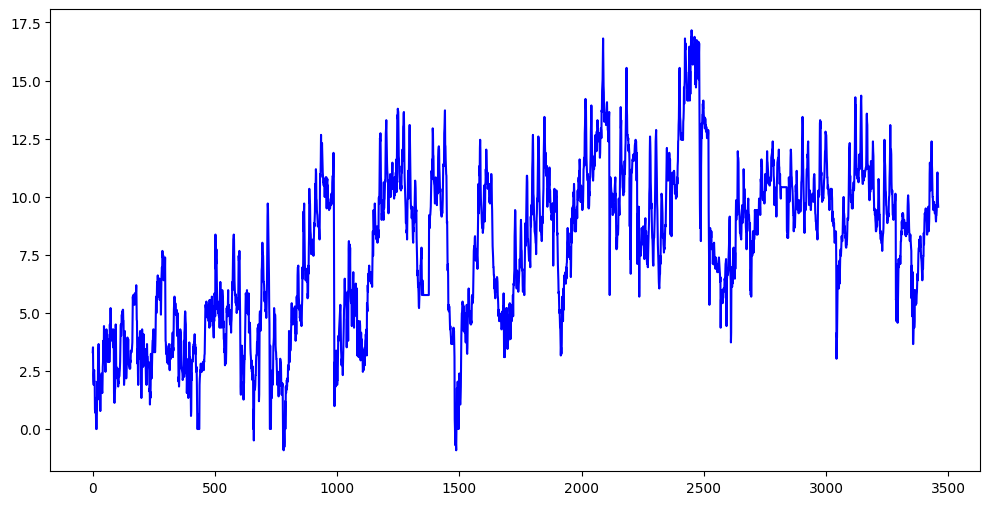

In [18]:
import numpy as np
import optuna
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Input, Dense, LSTM, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# =====================================================
# 0️⃣ GLOBAL CONSTANTS & PLACEHOLDERS
# (Replace these with your actual data logic)
# =====================================================

SEQ_LEN = SEQ_LEN     # Example sequence length
EPOCHS_OPT = 3   # Low epochs for optimization speed
EPOCHS_FINAL = EPOCHS
BATCH_SIZE = BATCH_SIZE

# =====================================================
# 1️⃣ Custom Attention Layer
# =====================================================

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        # u_it shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        
        # a_it shape: (batch, time_steps)
        a_it = tf.tensordot(u_it, self.u, axes=1)
        
        # Softmax over time dimension
        a_it = tf.nn.softmax(a_it, axis=1)
        
        # Expand for broadcasting: (batch, time_steps, 1)
        a_it = tf.expand_dims(a_it, axis=-1)
        
        # Weighted sum
        weighted_output = x * a_it
        
        # Sum over time steps -> (batch, features)
        return tf.reduce_sum(weighted_output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

    def get_config(self):
        # Good practice for saving custom layers
        return super(AttentionLayer, self).get_config()

# =====================================================
# 2️⃣ ATT-LSTM Model Builder
# =====================================================

def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, 
                        dense_units=32, dropout=0.2, lr=1e-3):
    
    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Attention
    att_out = AttentionLayer()(x)

    # Decoder LSTM
    # Reshape from (batch, features) to (batch, 1, features) to feed into next LSTM
    x = Reshape((1, lstm1_units))(att_out) 
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    
    # Updated 'lr' to 'learning_rate' for newer TF versions
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

    return model

# =====================================================
# 3️⃣ Objective function for Optuna
# =====================================================

def objective(trial):
    # Search space
    alpha = trial.suggest_float("alpha", 500, 3000)
    tau = trial.suggest_float("tau", 0.0, 0.5)
    K = trial.suggest_int("K", 3, 8)

    lstm1_units = trial.suggest_categorical("lstm1_units", [64, 96, 128, 160])
    lstm2_units = trial.suggest_categorical("lstm2_units", [32, 48, 64, 96])
    dense_units = trial.suggest_categorical("dense_units", [16, 32, 48, 64])

    # Generate dataset using VMD (Calls the placeholder function)
    # Note: We unpack only what we need, ignoring extra return values with *_
    (y_test_true, _, scaler_y,
     X_train_vmd, y_train_vmd,
     X_test_vmd, y_test_vmd, *_) = train_test(alpha, tau, K)

    # Build model
    # input_shape should be (Time Steps, Features)
    model = build_attlstm_model(
        input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
        lstm1_units=lstm1_units,
        lstm2_units=lstm2_units,
        dense_units=dense_units
    )

    # Fit (short run for optimization)
    history = model.fit(
        X_train_vmd, y_train_vmd,
        validation_data=(X_test_vmd, y_test_vmd),
        epochs=EPOCHS_OPT,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    return min(history.history["val_loss"])

# =====================================================
# 4️⃣ Run Bayesian Optimization
# =====================================================

# In Jupyter, we remove 'if __name__ == "__main__":' so variables persist
# You can install necessary packages by running:
# !pip install optuna tensorflow scikit-learn matplotlib

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5) # Reduced to 5 for quick testing

print("\n🏁 Best parameters found:")
print(study.best_params)
best_params = study.best_params

# =====================================================
# 5️⃣ Train final model
# =====================================================

alpha = best_params['alpha']
tau = best_params['tau']
K = best_params['K']
lstm1_units = best_params['lstm1_units']
lstm2_units = best_params['lstm2_units']
dense_units = best_params['dense_units']

# Regenerate data with best parameters
(y_test_true, _, scaler_y,
X_train_vmd, y_train_vmd,
X_test_vmd, y_test_vmd, *_) = train_test(alpha, tau, K)

model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=lstm1_units,
    lstm2_units=lstm2_units,
    dense_units=dense_units
)

model.summary()

history_bayes = model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and invert scaling
y_pred_attlstm_vmd_bayesian_scaled = model.predict(X_test_vmd)
y_pred_attlstm_vmd_bayesian_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_bayesian_scaled)

print("Prediction completed.")


# AttnLSTM+SIMPLE+GA


🧬 Generation 1/3
  Candidate 1: MSE = 0.0002, params = {'lstm1_units': 64, 'lstm2_units': 32, 'dense_units': 16}
  Candidate 2: MSE = 0.0002, params = {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 48}
  Candidate 3: MSE = 0.0002, params = {'lstm1_units': 64, 'lstm2_units': 48, 'dense_units': 64}
  Candidate 4: MSE = 0.0002, params = {'lstm1_units': 64, 'lstm2_units': 96, 'dense_units': 64}
  ✅ Best so far: {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 48}

🧬 Generation 2/3
  Candidate 1: MSE = 0.0002, params = {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 48}
  Candidate 2: MSE = 0.0002, params = {'lstm1_units': 64, 'lstm2_units': 96, 'dense_units': 64}
  Candidate 3: MSE = 0.0002, params = {'lstm1_units': 64, 'lstm2_units': 32, 'dense_units': 48}
  Candidate 4: MSE = 0.0002, params = {'lstm1_units': 64, 'lstm2_units': 48, 'dense_units': 48}
  ✅ Best so far: {'lstm1_units': 160, 'lstm2_units': 48, 'dense_units': 48}

🧬 Generation 3/3
  Candidate 1: MSE = 0.0

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 24, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_77 (LSTM)      │ (None, 24, 160)   │    107,520 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 24, 160)   │          0 │ lstm_77[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 24, 160)   │     25,760 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_101 (Dense)   │ (None, 24, 160)   │     25,760 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_12        │ (None, 24, 160)   │          0 │ dense_100[0][0],  │
│ (Attention)         │                   │            │ dense_101[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 24, 320)   │          0 │ dropout_65[0][0], │
│ (Concatenate)       │                   │            │ attention_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_78 (LSTM)      │ (None, 48)        │     70,848 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_102 (Dense)   │ (None, 48)        │      2,352 │ lstm_78[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 1)         │         49 │ dense_102[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 232,289 (907.38 KB)

 Trainable params: 232,289 (907.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0081 - mae: 0.0533 - val_loss: 9.1925e-04 - val_mae: 0.0245
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 3.8083e-04 - val_mae: 0.0147
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 7.3365e-04 - mae: 0.0202 - val_loss: 2.2119e-04 - val_mae: 0.0103
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.0721e-04 - mae: 0.0181 - val_loss: 1.9970e-04 - val_mae: 0.0098
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 5.2587e-04 - mae: 0.0167 - val_loss: 7.4870e-04 - val_mae: 0.0243
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 5.0187e-04 - mae: 0.0164 - val_loss: 1.9696e-04 - val_mae: 0.0100
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.2191e-04 - mae: 0.0168 - val_loss: 2.0205e-04 - val_mae: 0.0103
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.5663e-04 - mae: 0.0152 - val_loss: 2.6512e-04 - val_mae:

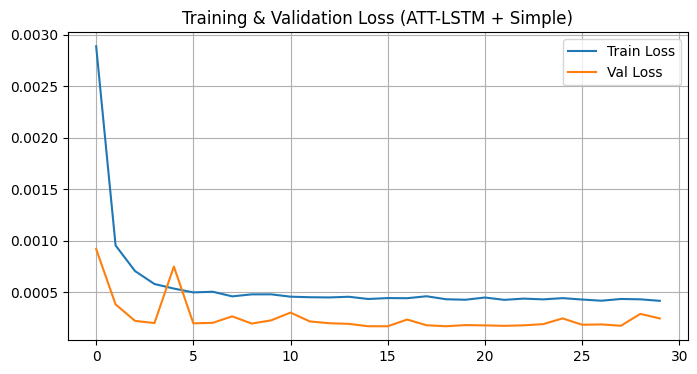

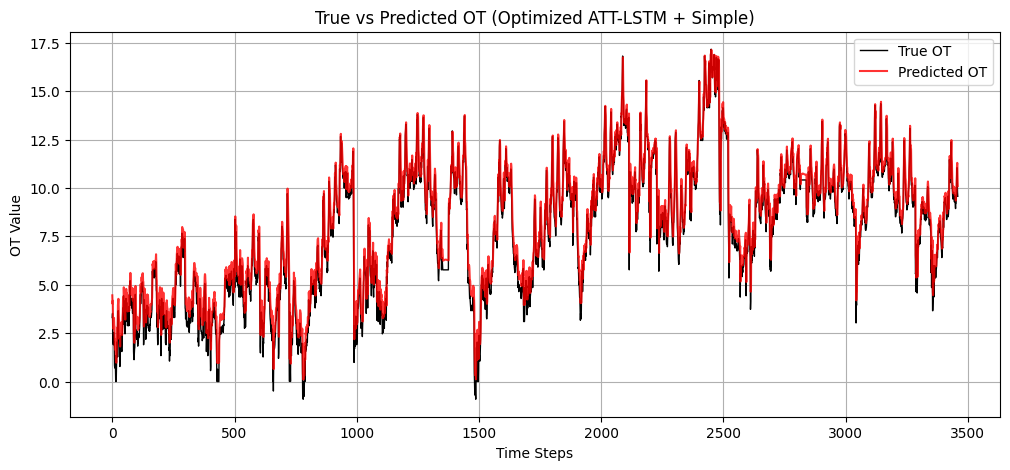

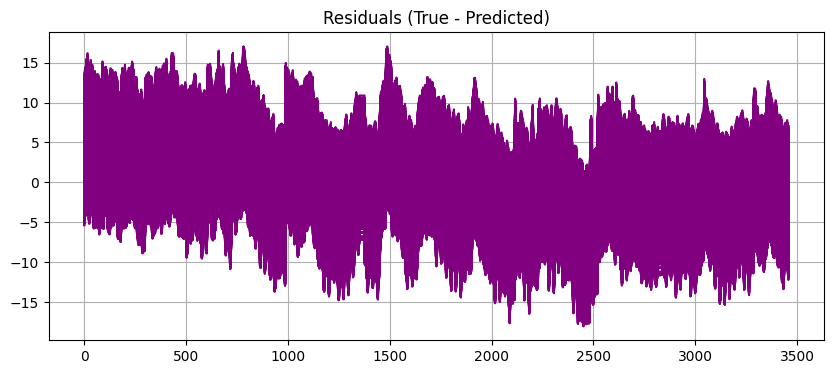

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from vmdpy import VMD
import random

# =====================================================
# 1️⃣ Global Config
# =====================================================
SEQ_LEN = SEQ_LEN        # sequence length
EPOCHS_OPT = 6           # epochs during GA fitness
EPOCHS_FINAL = EPOCHS    # final retraining

# =====================================================
# 2️⃣ ATT-LSTM Model Builder
# =====================================================
def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32):
    inp = Input(shape=input_shape)
    lstm_out = LSTM(lstm1_units, return_sequences=True)(inp)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention
    query = Dense(lstm1_units)(lstm_out)
    value = Dense(lstm1_units)(lstm_out)
    attention_out = Attention()([query, value])
    attention_out = Concatenate()([lstm_out, attention_out])

    # Decoder
    lstm_dec = LSTM(lstm2_units, return_sequences=False)(attention_out)
    dense_out = Dense(dense_units, activation='relu')(lstm_dec)
    final_out = Dense(1)(dense_out)

    model = Model(inputs=inp, outputs=final_out)
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
    return model

# =====================================================
# 4️⃣ Fitness Function (GA objective)
# =====================================================
def fitness(params, data):
    lstm1_units, lstm2_units, dense_units = (
        params['lstm1_units'], params['lstm2_units'], params['dense_units']
    )
    
    _,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 
   
    # --- Model ---
    k = 1
    model = build_attlstm_model(
        (SEQ_LEN, K),
        lstm1_units=lstm1_units,
        lstm2_units=lstm2_units,
        dense_units=dense_units
    )

    history = model.fit(
        X_train_simple, y_train_simple,
        validation_data=(X_test_simple, y_test_simple),
        epochs=EPOCHS_OPT,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    mse = min(history.history['val_loss'])
    return mse

# =====================================================
# 5️⃣ Genetic Algorithm (GA)
# =====================================================
def random_params():
    return {
        
        'lstm1_units': random.choice([64, 96, 128, 160]),
        'lstm2_units': random.choice([32, 48, 64, 96]),
        'dense_units': random.choice([16, 32, 48, 64])
    }

def mutate(params):
    new_params = params.copy()
    if random.random() < 0.4:
        new_params['lstm1_units'] = random.choice([64, 96, 128, 160])
    if random.random() < 0.4:
        new_params['lstm2_units'] = random.choice([32, 48, 64, 96])
    if random.random() < 0.4:
        new_params['dense_units'] = random.choice([16, 32, 48, 64])
    return new_params

def evolve_population(data, pop_size=4, generations=3):
    population = [random_params() for _ in range(pop_size)]
    for g in range(generations):
        print(f"\n🧬 Generation {g+1}/{generations}")
        scores = []
        for i, params in enumerate(population):
            mse = fitness(params, data)
            scores.append((mse, params))
            print(f"  Candidate {i+1}: MSE = {mse:.4f}, params = {params}")
        scores.sort(key=lambda x: x[0])
        best_params = scores[0][1]
        print(f"  ✅ Best so far: {best_params}")
        # Evolve
        new_pop = [scores[0][1], scores[1][1]]
        while len(new_pop) < pop_size:
            parent = random.choice(new_pop)
            new_pop.append(mutate(parent))
        population = new_pop
    return best_params

# =====================================================
# 6️⃣ Run Optimization
# =====================================================
best_params = evolve_population(df, pop_size=4, generations=3)
print("\n🏁 Best parameters found:", best_params)

# =====================================================
# 7️⃣ Retrain with Best Params (no leakage)
# =====================================================
lstm1_units, lstm2_units, dense_units = (
    best_params['lstm1_units'], best_params['lstm2_units'], best_params['dense_units']
)

_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

k = 1
model = build_attlstm_model((SEQ_LEN, K), lstm1_units, lstm2_units, dense_units)
model.summary()

history_attlstm_simple = model.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model.predict(X_test_simple)
y_pred_attlstm_simple_ga_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_ga_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_attlstm_simple_ga_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

# LSTM_SIMPLE

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 244)        │       121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 24, 244)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 24, 122)        │       179,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 24, 64)         │        47,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ (None, 122)            │        91,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 32)             │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,217 (1.69 MB)

 Trainable params: 443,217 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0117 - val_loss: 7.6024e-04
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0017 - val_loss: 3.7190e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0010 - val_loss: 3.3125e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 9.3453e-04 - val_loss: 0.0010
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 9.2647e-04 - val_loss: 2.8335e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 7.4020e-04 - val_loss: 3.4364e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 7.3828e-04 - val_loss: 4.6217e-04
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.8836e-04 - val_loss: 2.8640e-04
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.8366e-04 - val_loss: 2.1597e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 6.5314e-04 - val_loss: 2.5214e-04
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 6.63

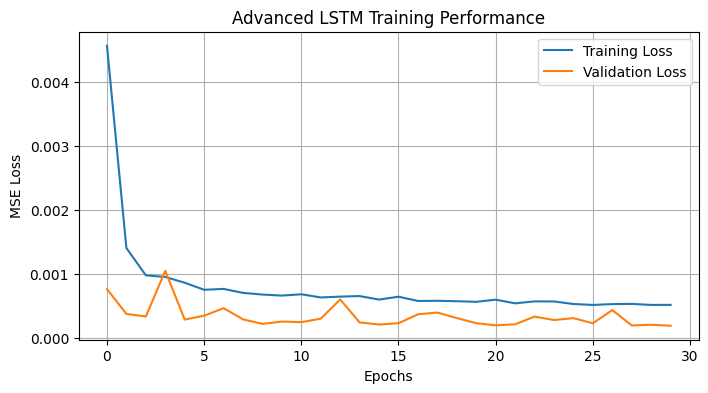

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


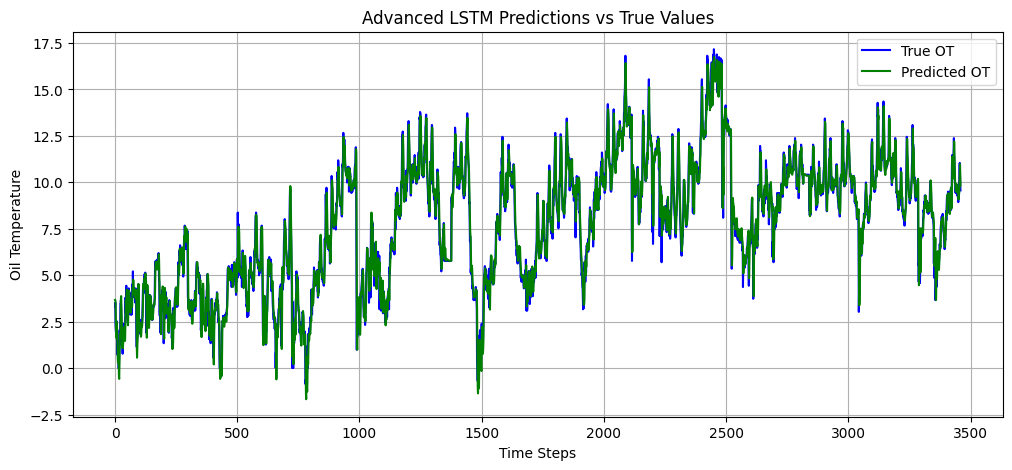

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test() 

# Advanced LSTM model
advanced_lstm = Sequential([
    Bidirectional(LSTM(122, return_sequences=True), input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(122, return_sequences=True),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(122, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

advanced_lstm.compile(optimizer='adam', loss='mse')
advanced_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_lstm_simple = advanced_lstm.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_lstm_simple.history['loss'], label='Training Loss')
plt.plot(history_lstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Advanced LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_lstm = advanced_lstm.predict(X_test_simple)
y_pred_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


# LSTM_VMD

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_84 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,857 (788.50 KB)

 Trainable params: 201,857 (788.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0091 - mae: 0.0568 - val_loss: 1.8840e-04 - val_mae: 0.0108
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8.9007e-04 - mae: 0.0227 - val_loss: 1.5778e-04 - val_mae: 0.0100
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7.1475e-04 - mae: 0.0202 - val_loss: 7.6287e-05 - val_mae: 0.0064
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.7730e-04 - mae: 0.0181 - val_loss: 5.5659e-05 - val_mae: 0.0055
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.7717e-04 - mae: 0.0181 - val_loss: 5.3458e-05 - val_mae: 0.0054
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.4490e-04 - mae: 0.0156 - val_loss: 4.2277e-05 - val_mae: 0.0048
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.1379e-04 - mae: 0.0153 - val_loss: 1.3036e-04 - val_mae: 0.0100
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.3666e-04 - mae: 0.0136 - val_loss: 3.2411e-05 - val_mae

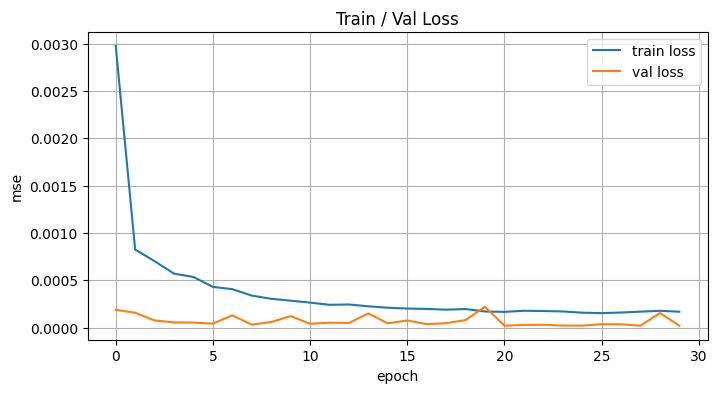

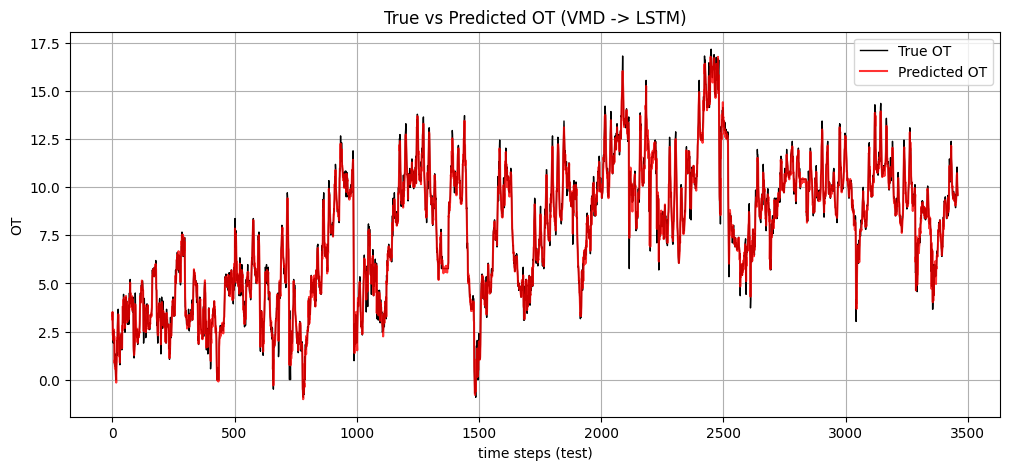

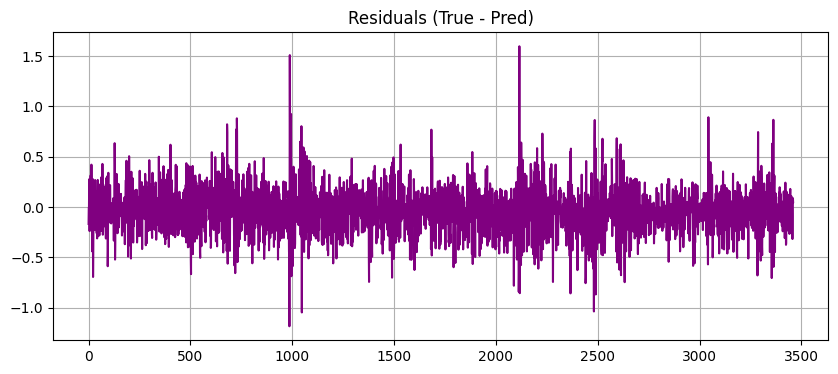

In [11]:
# Code: VMD -> LSTM (no leakage)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from vmdpy import VMD
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


_,y_test_vmd_true,_,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

# ---------------------------
# 5. Build LSTM model
# ---------------------------
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model = build_lstm_model((SEQ_LEN, K_hat))
model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_vmd_scaled = model.predict(X_test_vmd)
y_pred_lstm_vmd_true = scaler_y.inverse_transform(y_pred_lstm_vmd_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (VMD -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_pred_lstm_vmd_true - y_test_vmd_true
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()


# XLSTM_VMD

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xlstm (XLSTM)                   │ (None, 24, 128)        │        71,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_1 (XLSTM)                 │ (None, 24, 128)        │       148,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_2 (XLSTM)                 │ (None, 24, 64)         │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_88 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,833 (1.19 MB)

 Trainable params: 312,833 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0215 - val_loss: 0.0015
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0015 - val_loss: 1.2930e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 8.8988e-04 - val_loss: 7.5784e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 7.1002e-04 - val_loss: 9.7053e-05
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 5.7354e-04 - val_loss: 2.7451e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 4.7134e-04 - val_loss: 6.3407e-05
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.8954e-04 - val_loss: 1.6097e-04
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 3.7902e-04 - val_loss: 1.5121e-04
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.1565e-04 - val_loss: 1.1464e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 2.6285e-04 - val_loss: 2.0885e-04
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss:

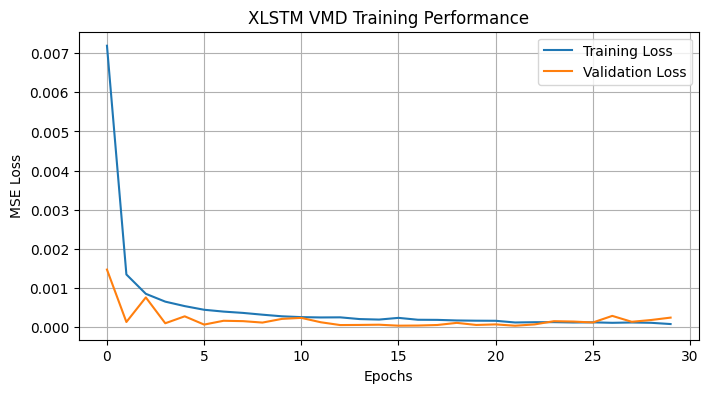

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


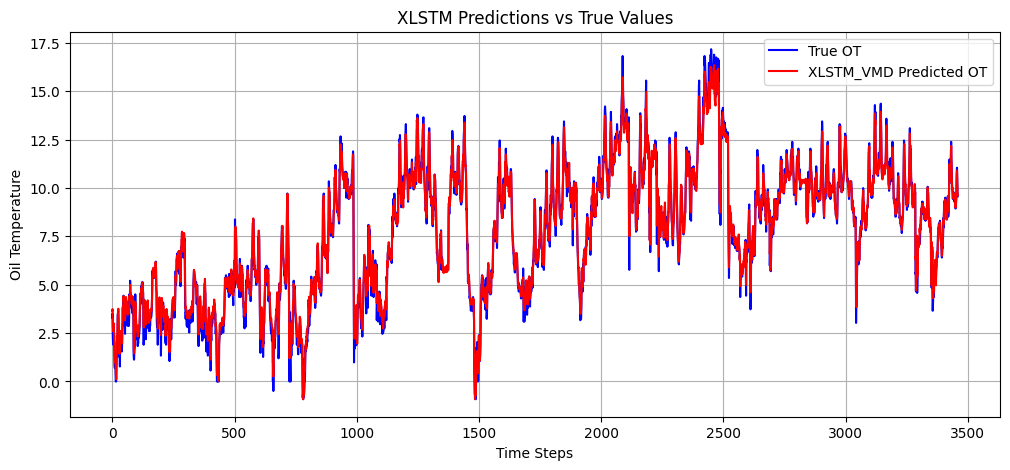

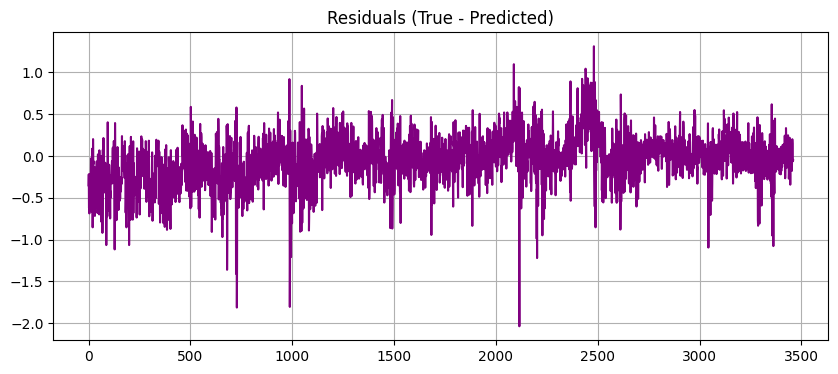

In [12]:
from tensorflow.keras.layers import Layer, LSTM, Dense, LayerNormalization, Dropout

class XLSTM(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(XLSTM, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)


# =============================
# XLSTM Model
# =============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Load data
_,y_test_vmd_true,_,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

# -----------------------------
# XLSTM Model Architecture
# -----------------------------

xlstm_model = Sequential([
    Input(shape=(SEQ_LEN, X_train_vmd.shape[-1])),  # automatic feature count
    XLSTM(128, dropout=0.2),
    XLSTM(128, dropout=0.2),
    XLSTM(64, dropout=0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

xlstm_model.compile(optimizer='adam', loss='mse')
xlstm_model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train XLSTM
history_xlstm_vmd = xlstm_model.fit(
    X_train_vmd, y_train_vmd,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_vmd, y_test_vmd),
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history_xlstm_vmd.history['loss'], label='Training Loss')
plt.plot(history_xlstm_vmd.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('XLSTM VMD Training Performance')
plt.legend()
plt.grid(True)
plt.show()

y_pred_xlstm_vmd_scaled = xlstm_model.predict(X_test_vmd)
y_pred_xlstm_vmd_true = scaler_y.inverse_transform(y_pred_xlstm_vmd_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label='True OT', color='blue')
plt.plot(y_pred_xlstm_vmd_true, label='XLSTM_VMD Predicted OT', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('XLSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_xlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


# XLSTM_SiMPLE

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xlstm_3 (XLSTM)                 │ (None, 24, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_4 (XLSTM)                 │ (None, 24, 128)        │       148,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xlstm_5 (XLSTM)                 │ (None, 24, 64)         │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,353 (1.18 MB)

 Trainable params: 308,353 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0143 - val_loss: 6.4293e-04
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0017 - val_loss: 7.1009e-04
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0012 - val_loss: 2.4953e-04
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 9.9083e-04 - val_loss: 4.4584e-04
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 8.4640e-04 - val_loss: 6.3732e-04
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 6.5398e-04 - val_loss: 6.7015e-04
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.7198e-04 - val_loss: 3.2213e-04
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.4565e-04 - val_loss: 5.5117e-04
Epoch 9/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.0331e-04 - val_loss: 2.1494e-04
Epoch 10/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 5.5848e-04 - val_loss: 2.8476e-04
Epoch 11/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss:

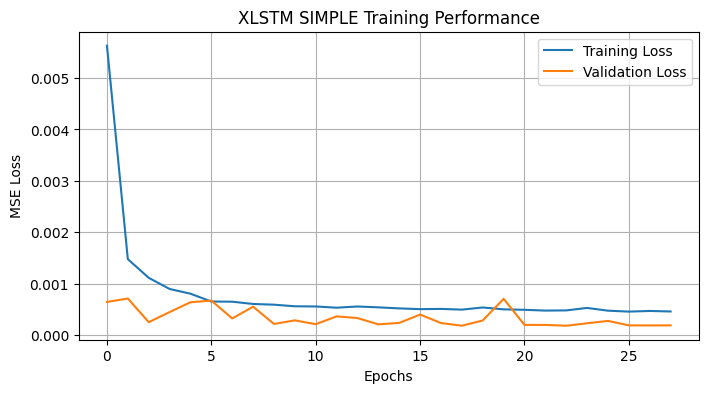

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


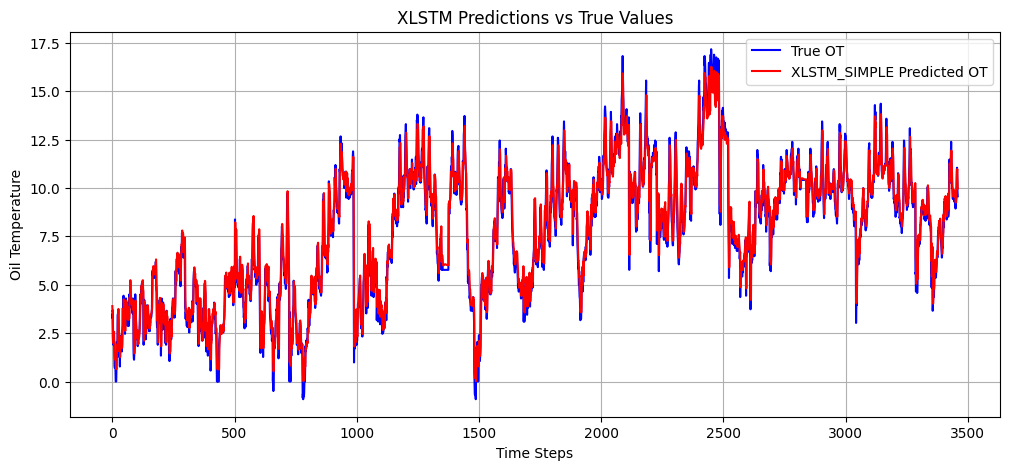

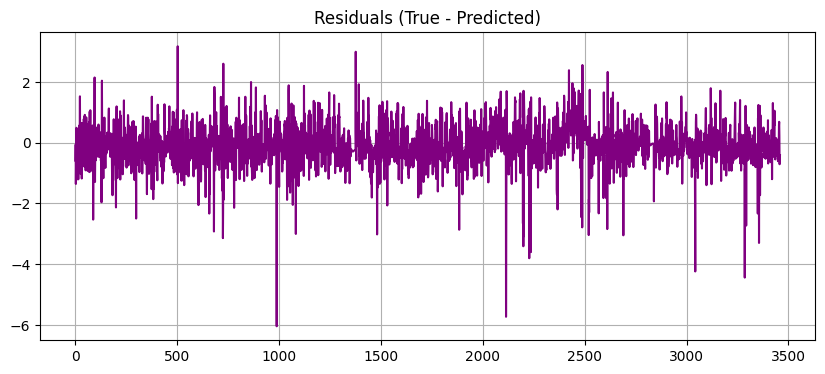

In [13]:
from tensorflow.keras.layers import Layer, LSTM, Dense, LayerNormalization, Dropout

class XLSTM(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(XLSTM, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)


# =============================
# XLSTM Model
# =============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Load data
_,y_test_simple_true,scaler_y,_,_,_,_,X_train_simple,y_train_simple,X_test_simple,y_test_simple = train_test()

# -----------------------------
# XLSTM Model Architecture
# -----------------------------

xlstm_model_simple = Sequential([
    Input(shape=(SEQ_LEN, X_train_simple.shape[-1])), # automatic feature count
    XLSTM(128, dropout=0.2),
    XLSTM(128, dropout=0.2),
    XLSTM(64, dropout=0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

xlstm_model_simple.compile(optimizer='adam', loss='mse')
xlstm_model_simple.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train XLSTM
history_xlstm_simple = xlstm_model_simple.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history_xlstm_simple.history['loss'], label='Training Loss')
plt.plot(history_xlstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('XLSTM SIMPLE Training Performance')
plt.legend()
plt.grid(True)
plt.show()

y_pred_xlstm_simple_scaled = xlstm_model_simple.predict(X_test_simple)
y_pred_xlstm_simple_true = scaler_y.inverse_transform(y_pred_xlstm_simple_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_xlstm_simple_true, label='XLSTM_SIMPLE Predicted OT', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('XLSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_xlstm_simple_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


#  XLSTM_SelfAttention_VMD

-Type of Attention Used in the this Model

The attention mechanism implemented in the this model is:

- ✅ **Luong Attention (Multiplicative / Dot-Product Attention)**  
A dot-product–based attention mechanism, identifiable through the use of `torch.bmm` or `matmul` operations.

---

- 📌 Main Reference

Luong, Thang, Hieu Pham, and Christopher D. Manning.  
**"Effective Approaches to Attention-based Neural Machine Translation."**  
*Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing (EMNLP)*, 2015.

- **DOI:** `10.18653/v1/D15-1166`  
- **Paper Link (ACL Anthology):** https://aclanthology.org/D15-1166/

---

- 📚 Why the this Attention Matches Luong Attention

- Uses **dot-product scoring** between `hidden` and `encoder_outputs`  
- No linear layers + `tanh` → therefore **not Bahdanau (Additive) Attention**  
- No `Q`, `K`, `V` projections and no `1/sqrt(d)` scaling → therefore **not Transformer Attention**  
- Matches exactly the **Multiplicative (Dot-Product) Attention** described in Luong et al., 2015



Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 24, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_6 (XLSTM)     │ (None, 24, 128)   │     71,552 │ input_layer_44[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_7 (XLSTM)     │ (None, 24, 128)   │    148,352 │ xlstm_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_8 (XLSTM)     │ (None, 24, 64)    │     57,792 │ xlstm_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 24, 128)   │      8,320 │ xlstm_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_121 (Dense)   │ (None, 24, 128)   │      8,320 │ xlstm_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_13        │ (None, 24, 128)   │          0 │ dense_120[0][0],  │
│ (Attention)         │                   │            │ dense_121[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 24, 192)   │          0 │ xlstm_8[0][0],    │
│ (Concatenate)       │                   │            │ attention_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_96 (LSTM)      │ (None, 48)        │     46,272 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_122 (Dense)   │ (None, 64)        │      3,136 │ lstm_96[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_123 (Dense)   │ (None, 1)         │         65 │ dense_122[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 343,809 (1.31 MB)

 Trainable params: 343,809 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0100 - mae: 0.0545 - val_loss: 1.5129e-04 - val_mae: 0.0092
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 6.9714e-04 - mae: 0.0207 - val_loss: 2.3807e-04 - val_mae: 0.0126
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 5.5534e-04 - mae: 0.0186 - val_loss: 6.8073e-04 - val_mae: 0.0245
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 3.5096e-04 - mae: 0.0145 - val_loss: 7.6940e-05 - val_mae: 0.0066
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 2.8560e-04 - mae: 0.0131 - val_loss: 5.9540e-05 - val_mae: 0.0057
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 2.4307e-04 - mae: 0.0122 - val_loss: 5.4112e-05 - val_mae: 0.0056
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.9618e-04 - mae: 0.0109 - val_loss: 1.8450e-04 - val_mae: 0.0123
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 2.0496e-04 - mae: 0.0113 - val_loss: 3.7147e-05 - val

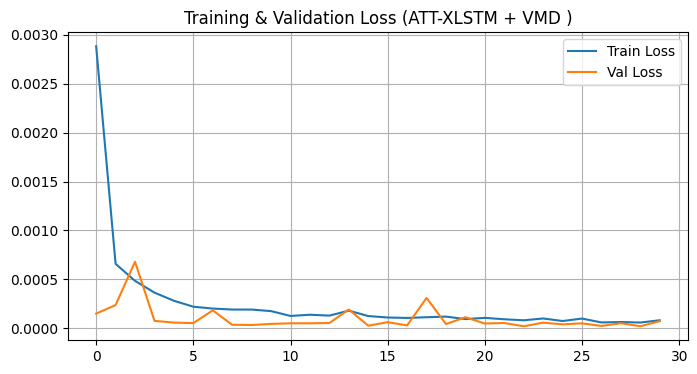

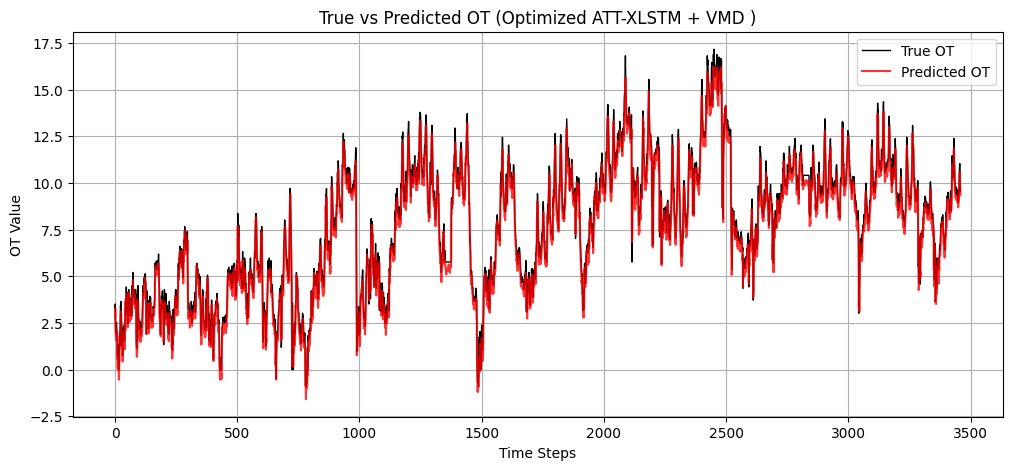

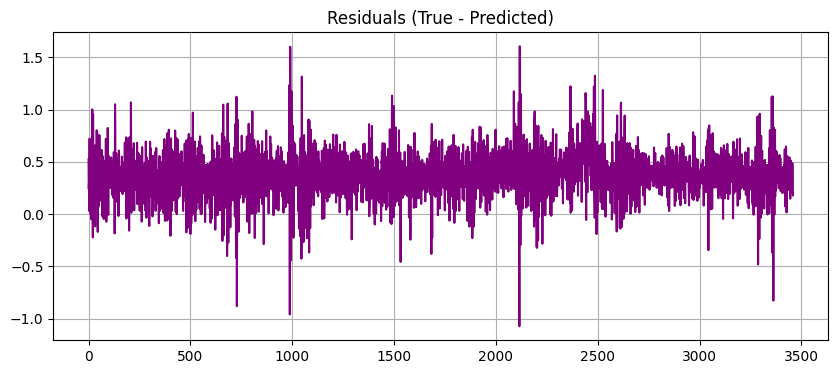

In [14]:
class XLSTM(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(XLSTM, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# Get final train/test split (no leakage)
y_test_vmd_true,_,_,X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd,_,_,_,_= train_test(alpha_hat, tau_hat, K_hat)

input_shape = (SEQ_LEN, X_train_vmd.shape[-1])
inp = Input(shape=input_shape)
x = XLSTM(128, dropout=0.2)(inp)
x = XLSTM(128, dropout=0.2)(x)
x = XLSTM(64, dropout=0.2)(x)

    # Self-Attention Layer
query = Dense(128)(x)
value = Dense(128)(x)
attention_out = Attention()([query, value])

    # Concatenate XLSTM + Attention output
attention_out = Concatenate()([x, attention_out])

    # Decoder LSTM
lstm_dec = LSTM(lstm2_units, return_sequences=False)(attention_out)
dense_out = Dense(64, activation='relu')(lstm_dec)
final_out = Dense(1)(dense_out)

model_xlstm_attlstm_vmd = Model(inputs=inp, outputs=final_out)
model_xlstm_attlstm_vmd.compile(optimizer='Adam', loss='mse', metrics=['mae'])

model_xlstm_attlstm_vmd.summary()

# Train final model
history_xlstm_attlstm_vmd = model_xlstm_attlstm_vmd.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_xlstm_attlstm_vmd_scaled = model_xlstm_attlstm_vmd.predict(X_test_vmd)
y_pred_xlstm_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_xlstm_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_xlstm_attlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_xlstm_attlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-XLSTM + VMD )')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_xlstm_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-XLSTM + VMD )')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_xlstm_attlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

# XLSTM + Luong + Multi-Head + Temporal + Cross-Attention + Causal Mask

title: XLSTM-FusionNet: A VMD-Driven Extended LSTM Architecture with Bahdanau, Luong, Multi-Head, and Causal Temporal Attention

- Luong (dot-product) attention
- Multi-Head Attention
- Temporal attention (learned weights over time steps)
- Cross-attention (VMD encoder ↔ optional extra encoder, e.g. short OT history)
- Causal masking (when supported, e.g. MultiHeadAttention)
- XLSTM
- VMD

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 24, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_9 (XLSTM)     │ (None, 24, 128)   │     71,552 │ input_layer_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_10 (XLSTM)    │ (None, 24, 128)   │    148,352 │ xlstm_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xlstm_11 (XLSTM)    │ (None, 24, 64)    │     57,792 │ xlstm_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_attention  │ (None, 64)        │      4,225 │ xlstm_11[0][0]    │
│ (TemporalAttention) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ luong_attention     │ (None, 24, 128)   │     16,640 │ xlstm_11[0][0],   │
│ (LuongAttention)    │                   │            │ xlstm_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 64)    │     33,216 │ xlstm_11[0][0],   │
│ (MultiHeadAttentio… │                   │            │ xlstm_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 24, 64)    │          0 │ temporal_attenti… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention     │ (None, 24, 64)    │     18,880 │ xlstm_11[0][0],   │
│ (CrossAttention)    │                   │            │ input_layer_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 24, 384)   │          0 │ xlstm_11[0][0],   │
│ (Concatenate)       │                   │            │ luong_attention[… │
│                     │                   │            │ multi_head_atten… │
│                     │                   │            │ repeat_vector[0]… │
│                     │                   │            │ cross_attention[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_100 (LSTM)     │ (None, 48)        │     83,136 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 64)        │      3,136 │ lstm_100[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 1)         │         65 │ dense_131[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,994 (1.67 MB)

 Trainable params: 436,994 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0148 - mae: 0.0688 - val_loss: 4.3419e-04 - val_mae: 0.0180
Epoch 2/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 5.9301e-04 - mae: 0.0189 - val_loss: 3.6973e-04 - val_mae: 0.0169
Epoch 3/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 5.2042e-04 - mae: 0.0180 - val_loss: 2.1928e-04 - val_mae: 0.0126
Epoch 4/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 3.7140e-04 - mae: 0.0149 - val_loss: 2.1556e-04 - val_mae: 0.0124
Epoch 5/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3.9661e-04 - mae: 0.0157 - val_loss: 3.1413e-04 - val_mae: 0.0161
Epoch 6/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2.5066e-04 - mae: 0.0123 - val_loss: 2.7806e-04 - val_mae: 0.0151
Epoch 7/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.8694e-04 - mae: 0.0107 - val_loss: 1.4703e-04 - val_mae: 0.0106
Epoch 8/30
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.5049e-04 - mae: 0.0097 - val_loss: 1.0740e-04 - val

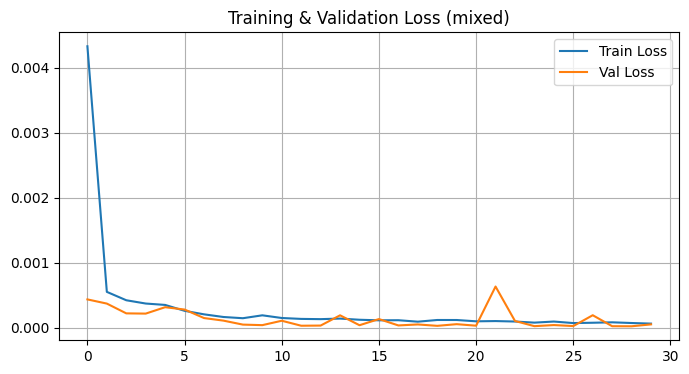

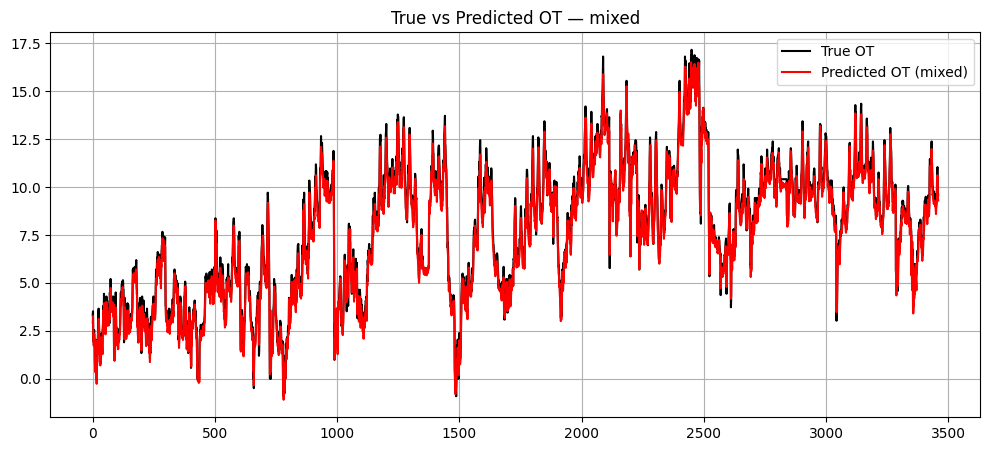

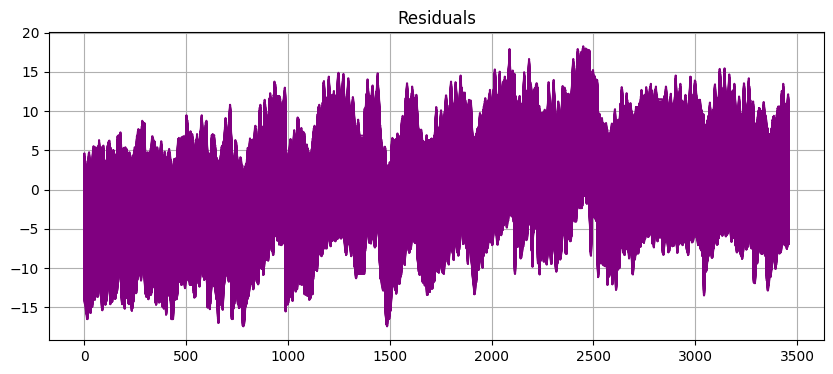

In [15]:
# =========================================================
# 📌 1 — XLSTM (unchanged)
# =========================================================
class XLSTM(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(XLSTM, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.proj = Dense(self.units)
        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)
        h_res = self.proj(x)
        return self.norm(h + h_res)


# =========================================================
# 📌 2 — Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context


        
# =========================================================
# 📌 3 — Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units):
        super().__init__()
        self.Wt = Dense(units)
        self.vt = Dense(1)

    def call(self, x):
        h = tf.nn.tanh(self.Wt(x))
        score = self.vt(h)
        alpha = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(alpha * x, axis=1)
        return context


# =========================================================
# 📌 4 — Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌 5 — Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]


# =========================================================
# 📌 6 — THE FINAL mehdiy_v2 MODEL
# =========================================================
def build_mehdiy_v2(input_shape, lstm2_units=64):

    seq_len = input_shape[0]
    inp = Input(shape=input_shape)

    # -------------------------------
    # (A) XLSTM BLOCKS
    # -------------------------------
    x = XLSTM(128, dropout=0.2)(inp)
    x = XLSTM(128, dropout=0.2)(x)
    x = XLSTM(64, dropout=0.2)(x)

    # =====================================================
    # (B) Attention Upgrade Pack
    # =====================================================

    # -------------------------------
    # 1) LUONG Attention
    # -------------------------------
    luong = LuongAttention(128)(x, x)

    # -------------------------------
    # 2) Multi-Head Attention with causal mask
    # -------------------------------
    mask = causal_mask(seq_len)
    mha = MultiHeadAttention(num_heads=4, key_dim=32)(x, x, attention_mask=mask)

    # -------------------------------
    # 3) Temporal Attention
    # -------------------------------
    temp_context = TemporalAttention(64)(x)
    temp_context = RepeatVector(seq_len)(temp_context)

    # -------------------------------
    # 4) Cross Attention (input → XLSTM)
    # -------------------------------
    cross = CrossAttention(num_heads=4, key_dim=32)(x, inp)

    # -------------------------------
    # COMBINE ALL ATTENTIONS
    # -------------------------------
    att_concat = Concatenate()([x, luong, mha, temp_context, cross])

    # -------------------------------
    # Decoder
    # -------------------------------
    lstm_dec = LSTM(lstm2_units, return_sequences=False)(att_concat)
    dense = Dense(64, activation='relu')(lstm_dec)
    out = Dense(1)(dense)

    return Model(inputs=inp, outputs=out)


# =================================================================
# 📌 7 — Training (same style as your mehdiy code)
# =================================================================
# Final non-leaking train/test
y_test_vmd_true, _, _, X_train_vmd, y_train_vmd, X_test_vmd, y_test_vmd, _, _, _, _ = train_test(alpha_hat, tau_hat, K_hat)

input_shape = (SEQ_LEN, X_train_vmd.shape[-1])
model_mixed = build_mehdiy_v2(input_shape=input_shape, lstm2_units=lstm2_units)

model_mixed.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_mixed.summary()

history_model_mixed = model_mixed.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS_FINAL,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predictions
y_pred_model_mixed_scaled = model_mixed.predict(X_test_vmd)
y_pred_model_mixed_true = scaler_y.inverse_transform(y_pred_model_mixed_scaled)


# =================================================================
# 📌 8 — PLOTTING (same format as mehdiy)
# =================================================================
plt.figure(figsize=(8, 4))
plt.plot(history_model_mixed.history['loss'], label='Train Loss')
plt.plot(history_model_mixed.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (mixed)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label='True OT', color='black')
plt.plot(y_pred_model_mixed_true, label='Predicted OT (mixed)', color='red')
plt.title('True vs Predicted OT — mixed')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true - y_pred_model_mixed_true.flatten()
plt.plot(residuals, color='purple')
plt.title('Residuals')
plt.grid(True); plt.show()


# Compare Models

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd_ga, rmse_Attlstm_vmd_ga, mae_Attlstm_vmd_ga, r2_attlstm_vmd_ga = compute_metrics(y_pred_attlstm_vmd_ga_true, y_test_vmd_true)
mse_Lstm_simple, rmse_Lstm_simple, mae_Lstm_simple, r2_Lstm_simple = compute_metrics(y_pred_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple_ga, rmse_Attlstm_simple_ga, mae_Attlstm_simple_ga, r2_attlstm_simple_ga = compute_metrics(y_pred_attlstm_simple_ga_true, y_test_simple_true)
mse_Lstm_vmd, rmse_Lstm_vmd, mae_Lstm_vmd, r2_Lstm_vmd = compute_metrics(y_pred_lstm_vmd_true, y_test_vmd_true)
mse_XLstm_vmd, rmse_XLstm_vmd, mae_XLstm_vmd, r2_XLstm_vmd = compute_metrics(y_pred_xlstm_vmd_true, y_test_vmd_true)
mse_XLstm_simple, rmse_XLstm_simple, mae_XLstm_simple, r2_XLstm_simple = compute_metrics(y_pred_xlstm_simple_true, y_test_simple_true)
mse_AttLstm_XLstm_vmd, rmse_AttLstm_XLstm_vmd, mae_AttLstm_XLstm_vmd, r2_AttLstm_XLstm_vmd = compute_metrics(y_pred_xlstm_attlstm_vmd_true, y_test_vmd_true)
mse_mixed, rmse_mixed, mae_mixed, r2_mixed = compute_metrics(y_pred_model_mixed_true, y_test_vmd_true)
mse_attlstm_vmd_bayesian, rmse_attlstm_vmd_bayesian, mae_attlstm_vmd_bayesian, r2_attlstm_vmd_bayesian = compute_metrics(y_pred_attlstm_vmd_bayesian_true, y_test_vmd_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM-VMD-GA: MSE={mse_Attlstm_vmd_ga:.4f}, RMSE={rmse_Attlstm_vmd_ga:.4f}, MAE={mae_Attlstm_vmd_ga:.4f}, R²={r2_attlstm_vmd_ga:.4f}")
print(f"Lstm_Simple: MSE={mse_Lstm_simple:.4f}, RMSE={rmse_Lstm_simple:.4f}, MAE={mae_Lstm_simple:.4f}, R²={r2_Lstm_simple:.4f}")
print(f"Attlstm_Simple_GA: MSE={mse_Attlstm_simple_ga:.4f}, RMSE={rmse_Attlstm_simple_ga:.4f}, MAE={mae_Attlstm_simple_ga:.4f}, R²={r2_attlstm_simple_ga:.4f}")
print(f"Lstm_vmd: MSE={mse_Lstm_vmd:.4f}, RMSE={rmse_Lstm_vmd:.4f}, MAE={mae_Lstm_vmd:.4f}, R²={r2_Lstm_vmd:.4f}")
print(f"XLstm_vmd: MSE={mse_XLstm_vmd:.4f}, RMSE={rmse_XLstm_vmd:.4f}, MAE={mae_XLstm_vmd:.4f}, R²={r2_XLstm_vmd:.4f}")
print(f"XLstm_simple: MSE={mse_XLstm_simple:.4f}, RMSE={rmse_XLstm_simple:.4f}, MAE={mae_XLstm_simple:.4f}, R²={r2_XLstm_simple:.4f}")
print(f"AttLSTM_XLSTM_VMD: MSE={mse_AttLstm_XLstm_vmd:.4f}, RMSE={rmse_AttLstm_XLstm_vmd:.4f}, MAE={mae_AttLstm_XLstm_vmd:.4f}, R²={r2_AttLstm_XLstm_vmd:.4f}")
print(f"MIXED: MSE={mse_mixed:.4f}, RMSE={rmse_mixed:.4f}, MAE={mae_mixed:.4f}, R²={r2_mixed:.4f}")
print(f"Att-LSTM-VMD-BAYESIAN: MSE={mse_attlstm_vmd_bayesian:.4f}, RMSE={rmse_attlstm_vmd_bayesian:.4f}, MAE={mae_attlstm_vmd_bayesian:.4f}, R²={r2_attlstm_vmd_bayesian:.4f}")


📈 Model Performance Comparison
ATT-LSTM-VMD-GA: MSE=0.5619, RMSE=0.7496, MAE=0.5838, R²=0.9516
Lstm_Simple: MSE=0.4692, RMSE=0.6850, MAE=0.4713, R²=0.9598
Attlstm_Simple_GA: MSE=0.6132, RMSE=0.7830, MAE=0.5907, R²=0.9419
Lstm_vmd: MSE=0.0513, RMSE=0.2265, MAE=0.1694, R²=0.9955
XLstm_vmd: MSE=0.0862, RMSE=0.2936, MAE=0.2168, R²=0.9919
XLstm_simple: MSE=0.4530, RMSE=0.6730, MAE=0.4753, R²=0.9583
AttLSTM_XLSTM_VMD: MSE=0.1860, RMSE=0.4312, MAE=0.3846, R²=0.9841
MIXED: MSE=0.1250, RMSE=0.3536, MAE=0.3026, R²=0.9891
Att-LSTM-VMD-BAYESIAN: MSE=2.2778, RMSE=1.5092, MAE=1.0811, R²=0.7766


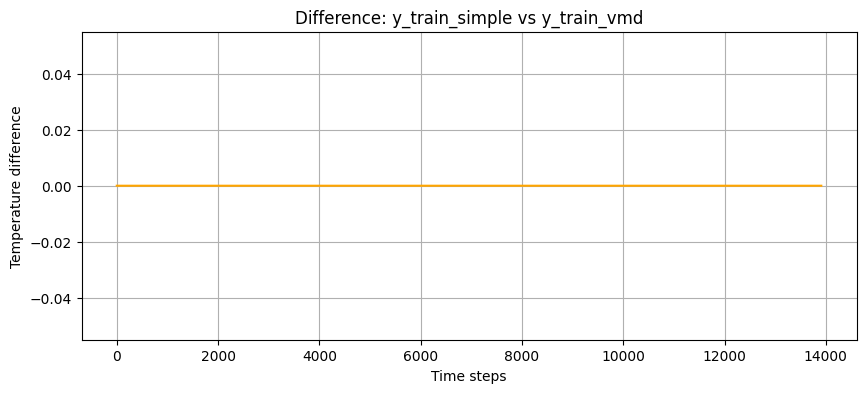

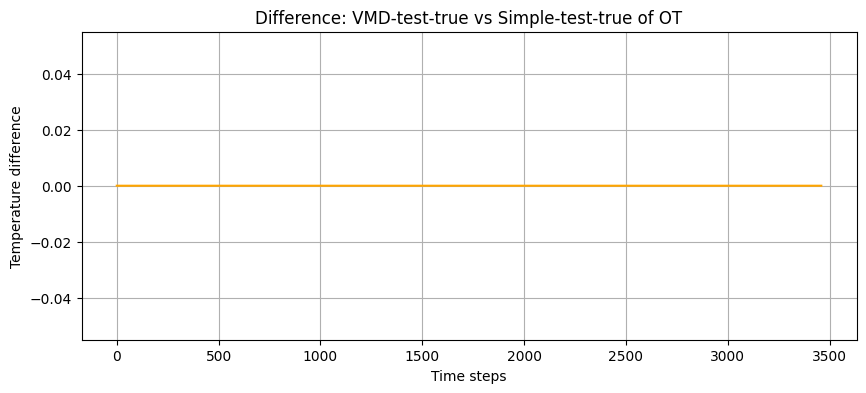

In [17]:
diff = y_train_simple - y_train_vmd
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: y_train_simple vs y_train_vmd')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()

y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple)
diff = y_test_simple_true - y_test_vmd_true
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: VMD-test-true vs Simple-test-true of OT')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()